In [11]:
import PIL,torch
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import os
import time
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from torchvision.models import resnet50
from pytorchcv.model_provider import get_model as ptcv_get_model

In [12]:
class SkinDataset(Dataset):
    folds=5
    def __init__(self, root , num_classes,fold=0,training=False,n_augment=2):
        self.data_path = []
        self.sides =448
        self.n_augment = max(n_augment , 4)
        self.transform = transforms.Compose([
                transforms.RandomResizedCrop(size=(224, 224)),
                transforms.RandomRotation(5),
                transforms.ToTensor(),
                transforms.Normalize(mean= [0.6075306,0.49116918 ,0.46066117],std = [0.22603881, 0.21623525, 0.2191065 ])
            ]
            )
        self.training = training
        for label in range(num_classes):
            self.data_dir = os.path.join(root,os.listdir(root)[label])
            self.filename = os.listdir(self.data_dir)
            l = len(self.filename)
            inter = l//SkinDataset.folds
            picked = list(range(inter* fold,inter * (fold+1))) if not training else list(range(0,inter*fold))+list(range(inter*(fold+1),l))

            for i in picked:
                file_path = os.path.join(self.data_dir , self.filename[i])
#                 img = Image.open(fil)
                self.data_path.append((file_path, label))
    
    def __getitem__(self , index):
        index %= len(self.data_path)
        ddir , label = self.data_path[index]
        img = Image.open(ddir)
        imgmat = self.transform(img)
#         if self.training:
#             imgmat += torch.randn(3,self.sides,self.sides)/256
        result = (imgmat, label)
        del imgmat
        del img
        return result
    
    def __len__(self):
        return len(self.data_path)*self.n_augment

In [13]:
# del training_dataloader
batch_size = 128
lr = 0.1
suffix = '%f' % time.time()
log_dir = './log/%s'% suffix +'/'
EXPERIMENT = 'resnet50_%s'% str(lr)
os.mkdir(log_dir)
print(suffix)
print(log_dir)
print(EXPERIMENT)

training_dataset = SkinDataset(os.path.join(os.getcwd(),'./Skin40'), 40, training=True)
test_dataset = SkinDataset(os.path.join(os.getcwd(),'./Skin40'), 40)
training_dataloader = DataLoader(training_dataset , batch_size = batch_size , num_workers = 1, shuffle = True)
test_dataloader = DataLoader(test_dataset , batch_size = batch_size , num_workers = 1, shuffle = True)

1593763699.666078
./log/1593763699.666078/
resnet50_0.1


In [14]:
def train(model, train_loader, loss_func, optimizer, device):
    """
    train model using loss_fn and optimizer in an epoch.
    model: CNN networks
    train_loader: a Dataloader object with training data
    loss_func: loss function
    device: train on cpu or gpu device
    """
    total_loss = 0
    model.train()
    # train the model using minibatch
    for i, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = targets.to(device)
        
        # forward
        outputs = model(images)
        loss = loss_func(outputs, targets)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # every  iterations, print loss
        if (i + 1) % (10) == 0:
            print ("Step [{}/{}] Train Loss: {:.4f}"
                   .format(i+1, len(train_loader), loss.item()))
    return total_loss / len(train_loader)

In [15]:
def evaluate(model, val_loader, device, nclasses):
    """
    model: CNN networks
    val_loader: a Dataloader object with validation data
    device: evaluate on cpu or gpu device
    return classification accuracy of the model on val dataset
    """
    # evaluate the model
    model.eval()
    # context-manager that disabled gradient computation
    with torch.no_grad():
        correct = 0
        total = 0
        cm = torch.zeros(nclasses, nclasses)
        for i, (images, targets) in enumerate(val_loader):
            # device: cpu or gpu
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            
            
            for t, p in zip(targets.view(-1), predicted.view(-1)):
                cm[t.long()][p.long()] +=1
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
        accuracy = correct / total
        print('Accuracy on Test Set: {:.4f} %'.format(100 * accuracy))
        show_heatmap(cm, nclasses)
        return accuracy,cm

In [16]:
import matplotlib.pyplot as plt
def show_curve(ys, title):
    """
    plot curlve for Loss and Accuacy
    Args:
        ys: loss or acc list
        title: loss or accuracy
    """
    x = np.array(range(len(ys)))
    y = np.array(ys)
    plt.plot(x, y, c='b')
    plt.axis()
    plt.title('{} curve'.format(title))
    plt.xlabel('epoch')
    plt.ylabel('{}'.format(title))
    plt.show()

def show_heatmap(cm, nclasses):
    labels = range(nclasses)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.set_yticks(labels)
    ax.set_yticklabels(labels)
    ax.set_xticks(labels)
    ax.set_xticklabels(labels)
    
    im = ax.imshow(cm, cmap=plt.cm.hot_r )
    plt.colorbar(im)
    plt.title("Confusioin Matrix")
    plt.show()
    print('Accuracy of each class:\n', cm.diag()/(cm.sum(1)+1e-6))
    print('Recall of each class:\n', cm.diag()/(cm.sum(0)+1e-6))

In [17]:
def fit(model, num_epochs, optimizer, schedulr, device,nclasses):
    """
     train and evaluate an classifier num_epochs times.
    n and evaluate an classifier num_epochs times.
    We use optimizer and cross entropy loss to train the model. 
    Args: 
        model: CNN network
        num_epochs: the number of training epochs
        optimizer: optimize the loss function    loss_func.to(device)
    loss_func.to(device)
        schedulr: scheduling learning rate

    """
    # loss and optimizer
    loss_func = nn.CrossEntropyLoss()
    
    model.to(device)
    loss_func.to(device)
    
    # log train loss and test accuracy
    losses = []
    accs = []
    cms = []
    for epoch in range(num_epochs):
        
        print('Epoch {}/{}: , lr = {}'.format(epoch + 1, num_epochs , optimizer.param_groups[0]['lr']))
        # train step
        loss = train(model, training_dataloader, loss_func, optimizer, device)
        losses.append(loss)
        schedulr.step()
        
        # evaluate step
        accuracy,cm = evaluate(model, test_dataloader, device,nclasses)
        accs.append(accuracy)
        cms.append(cm)
    torch.save(model.state_dict(), log_dir+EXPERIMENT+".pth")
    # show curve
    show_curve(losses, "train loss")
    show_curve(accs, "test accuracy")

In [18]:
net = ptcv_get_model("resattnet56", num_classes=40)

In [19]:
# Hyper-parameters
num_epochs = 40
nclasses = 40
feature_tune=False
# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # optimizer
#optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=0.1)
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
schedulr = torch.optim.lr_scheduler.StepLR(optimizer , step_size = 4 , gamma = 0.5)

Epoch 1/40: , lr = 0.2
Step [10/60] Train Loss: 4.0073
Step [20/60] Train Loss: 3.7204
Step [30/60] Train Loss: 3.7141
Step [40/60] Train Loss: 3.5953
Step [50/60] Train Loss: 3.5794
Step [60/60] Train Loss: 3.3708
Accuracy on Test Set: 7.1875 %


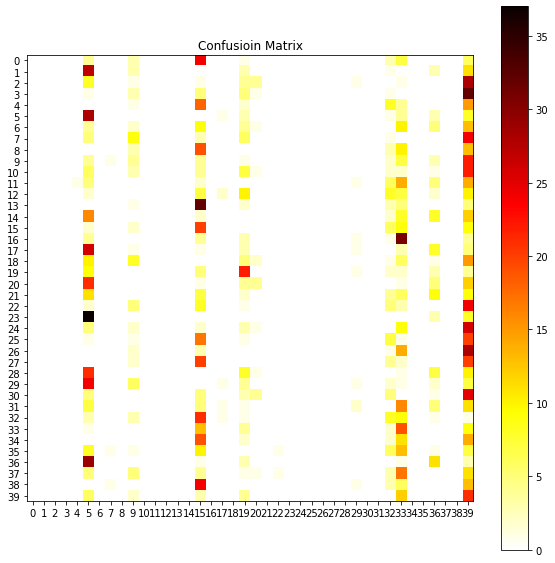

Accuracy of each class:
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5833, 0.0000, 0.0000, 0.0000,
        0.0833, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4167, 0.0000, 0.0000,
        0.0000, 0.4583, 0.0833, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0208, 0.0000, 0.0000, 0.1667, 0.3958, 0.0000, 0.0000,
        0.2292, 0.0000, 0.0000, 0.4375])
Recall of each class:
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0807, 0.0000, 0.0000, 0.0000,
        0.0548, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0619, 0.0000, 0.0000,
        0.0000, 0.1789, 0.2000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.1111, 0.0000, 0.0000, 0.0777, 0.0699, 0.0000, 0.0000,
        0.1264, 0.0000, 0.0000, 0.0381])
Epoch 2/40: , lr = 0.2
Step [10/60] Train Loss: 3.4427
Step [20/60] Train Loss: 3.3584
Step [30/60] Train Loss: 3.3945
Step [40/60] Train Loss: 3.1136
Step [50/60] Train Loss: 3.2011
Step [60/60] Train Loss: 3.2996
Accuracy on Tes

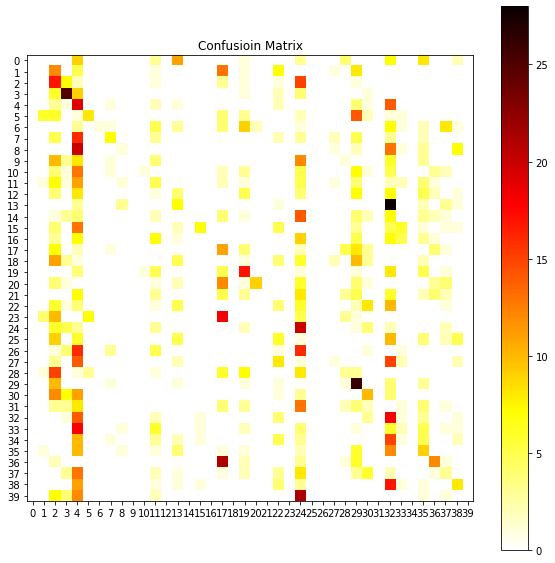

Accuracy of each class:
 tensor([0.0000, 0.0000, 0.3542, 0.5208, 0.3958, 0.1667, 0.0208, 0.1458, 0.0208,
        0.0000, 0.0208, 0.1042, 0.0000, 0.1458, 0.0000, 0.1458, 0.0000, 0.2292,
        0.0000, 0.3542, 0.1875, 0.0000, 0.0833, 0.0000, 0.4167, 0.0000, 0.0000,
        0.0208, 0.0625, 0.5417, 0.2083, 0.0000, 0.3750, 0.0417, 0.0000, 0.1875,
        0.2500, 0.0625, 0.1667, 0.0000])
Recall of each class:
 tensor([0.0000, 0.0000, 0.0904, 0.3425, 0.0601, 0.4444, 1.0000, 0.4118, 0.1429,
        0.0000, 0.5000, 0.0714, 0.0000, 0.1228, 0.0000, 0.6364, 0.0000, 0.0948,
        0.0000, 0.2361, 0.8182, 0.0000, 0.0656, 0.0000, 0.0922, 0.0000, 0.0000,
        0.1250, 0.1304, 0.1793, 0.2083, 0.0000, 0.0747, 0.0800, 0.0000, 0.1125,
        0.3636, 0.0857, 0.2500, 0.0000])
Epoch 3/40: , lr = 0.2
Step [10/60] Train Loss: 3.0894
Step [20/60] Train Loss: 3.0054
Step [30/60] Train Loss: 3.1085
Step [40/60] Train Loss: 3.1856
Step [50/60] Train Loss: 3.1551
Step [60/60] Train Loss: 3.0598
Accuracy on Tes

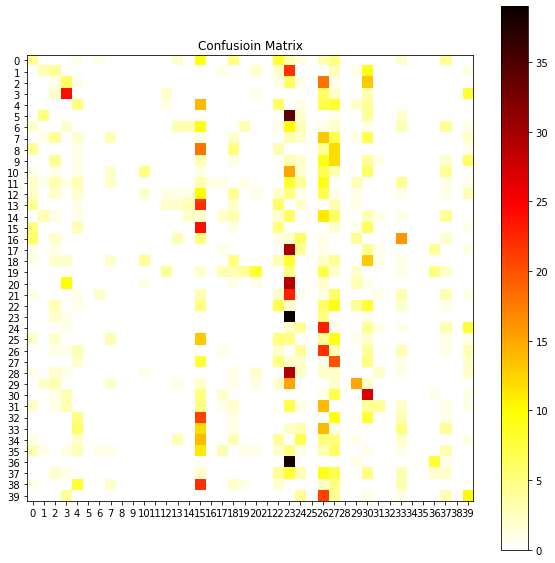

Accuracy of each class:
 tensor([0.0833, 0.0625, 0.0208, 0.5000, 0.1042, 0.0000, 0.0000, 0.0625, 0.0000,
        0.0000, 0.1042, 0.0000, 0.0208, 0.0417, 0.0417, 0.5000, 0.0000, 0.0208,
        0.1042, 0.0833, 0.0208, 0.0000, 0.1458, 0.8125, 0.0833, 0.0000, 0.4583,
        0.4167, 0.0000, 0.3125, 0.5625, 0.0833, 0.0000, 0.1042, 0.0000, 0.0000,
        0.1667, 0.0417, 0.0000, 0.2083])
Recall of each class:
 tensor([0.0930, 0.1875, 0.0227, 0.3934, 0.0943, 0.0000, 0.0000, 0.1765, 0.0000,
        0.0000, 0.3846, 0.0000, 0.1000, 0.1333, 0.2222, 0.0976, 0.0000, 0.0667,
        0.1163, 0.4000, 0.0588, 0.0000, 0.0933, 0.1066, 0.0635, 0.0000, 0.0913,
        0.1176, 0.0000, 0.3659, 0.1800, 0.3333, 0.0000, 0.0806, 0.0000, 0.0000,
        0.4000, 0.0417, 0.0000, 0.1818])
Epoch 4/40: , lr = 0.2
Step [10/60] Train Loss: 3.0694
Step [20/60] Train Loss: 3.0764
Step [30/60] Train Loss: 2.9858
Step [40/60] Train Loss: 2.8195
Step [50/60] Train Loss: 2.9102
Step [60/60] Train Loss: 2.6839
Accuracy on Tes

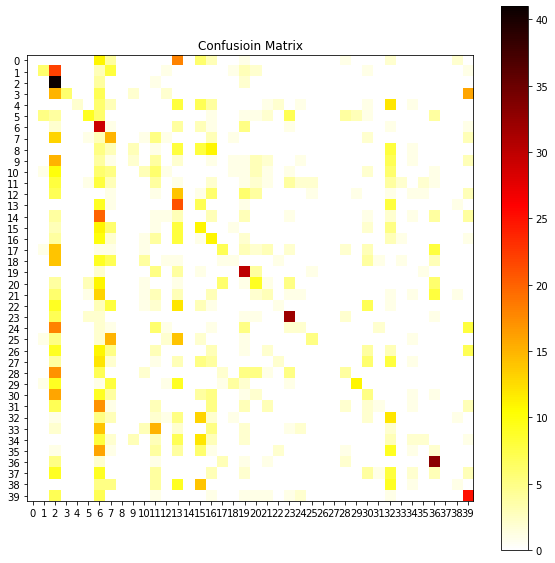

Accuracy of each class:
 tensor([0.0000, 0.1250, 0.8542, 0.1250, 0.0417, 0.1875, 0.6042, 0.3125, 0.0000,
        0.0417, 0.0625, 0.0833, 0.0000, 0.4375, 0.0000, 0.2292, 0.2292, 0.1458,
        0.0208, 0.6250, 0.1875, 0.0625, 0.0208, 0.6667, 0.0417, 0.1042, 0.0000,
        0.0000, 0.0833, 0.2292, 0.1042, 0.0208, 0.2500, 0.0000, 0.0417, 0.0000,
        0.6875, 0.0000, 0.0208, 0.5208])
Recall of each class:
 tensor([0.0000, 0.4000, 0.1314, 1.0000, 1.0000, 0.5294, 0.0935, 0.1293, 0.0000,
        0.2000, 0.1667, 0.0471, 0.0000, 0.1243, 0.0000, 0.1058, 0.1325, 0.3500,
        0.0909, 0.3409, 0.2195, 0.1364, 0.1250, 0.5000, 0.1818, 0.5556, 0.0000,
        0.0000, 0.2222, 0.7333, 0.1064, 0.2000, 0.1034, 0.0000, 0.1250, 0.0000,
        0.4400, 0.0000, 0.1667, 0.3165])
Epoch 5/40: , lr = 0.1
Step [10/60] Train Loss: 2.7229
Step [20/60] Train Loss: 2.5820
Step [30/60] Train Loss: 2.8158
Step [40/60] Train Loss: 2.5795
Step [50/60] Train Loss: 2.4669
Step [60/60] Train Loss: 2.7803
Accuracy on Tes

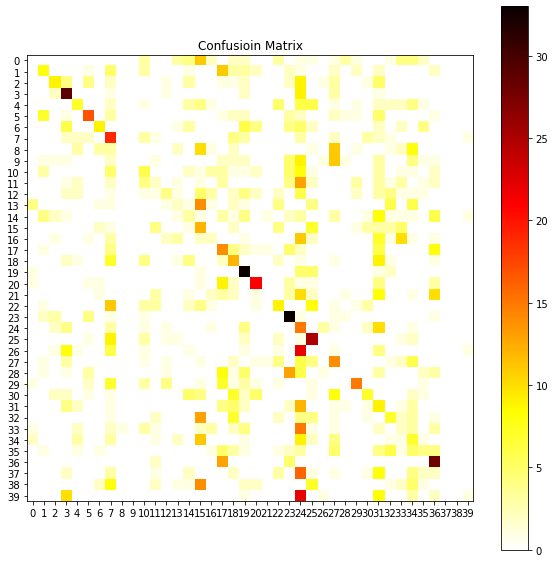

Accuracy of each class:
 tensor([0.0000, 0.1667, 0.1875, 0.6042, 0.1458, 0.3542, 0.1875, 0.3958, 0.0000,
        0.0000, 0.1250, 0.0417, 0.0833, 0.0417, 0.0625, 0.2500, 0.0417, 0.2917,
        0.2500, 0.6875, 0.4375, 0.0000, 0.1875, 0.6875, 0.3125, 0.5208, 0.0000,
        0.2917, 0.0000, 0.3125, 0.1458, 0.1875, 0.1458, 0.0417, 0.1458, 0.0833,
        0.5833, 0.0000, 0.0000, 0.0208])
Recall of each class:
 tensor([0.0000, 0.2667, 0.3913, 0.3494, 0.2692, 0.4595, 0.4500, 0.1624, 0.0000,
        0.0000, 0.1463, 0.0833, 0.2353, 0.1053, 0.0811, 0.1062, 0.0952, 0.1573,
        0.1622, 0.3438, 0.4884, 0.0000, 0.2093, 0.3548, 0.0633, 0.2841, 0.0000,
        0.1772, 0.0000, 0.5357, 0.3043, 0.0720, 0.1750, 0.0465, 0.0933, 0.1818,
        0.3457, 0.0000, 0.0000, 0.2500])
Epoch 6/40: , lr = 0.1
Step [10/60] Train Loss: 2.5371
Step [20/60] Train Loss: 2.7688
Step [30/60] Train Loss: 2.4033
Step [40/60] Train Loss: 2.6956
Step [50/60] Train Loss: 2.5962
Step [60/60] Train Loss: 2.5697
Accuracy on Tes

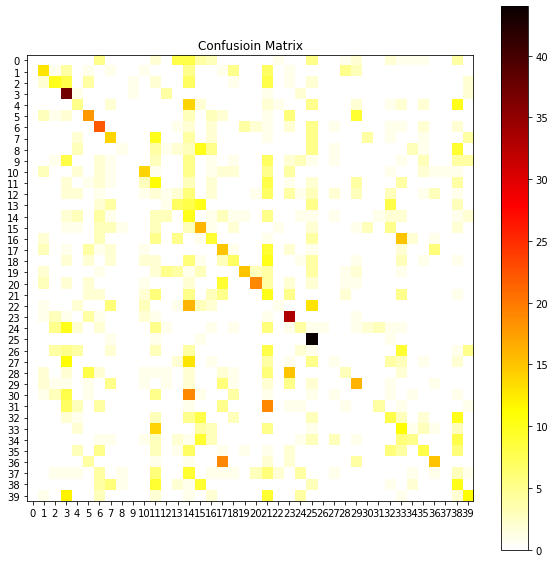

Accuracy of each class:
 tensor([0.0000, 0.2708, 0.2083, 0.7708, 0.1042, 0.3750, 0.4583, 0.2917, 0.0208,
        0.0000, 0.2917, 0.2292, 0.0208, 0.1458, 0.2083, 0.3333, 0.1875, 0.3125,
        0.1458, 0.3125, 0.3958, 0.2083, 0.0208, 0.6875, 0.0833, 0.9167, 0.0000,
        0.0208, 0.0625, 0.3333, 0.0000, 0.0833, 0.1667, 0.2292, 0.1042, 0.1667,
        0.3125, 0.0000, 0.2083, 0.2292])
Recall of each class:
 tensor([0.0000, 0.3333, 0.3333, 0.2824, 0.1351, 0.3462, 0.2895, 0.2642, 0.2500,
        0.0000, 0.4242, 0.0973, 0.0556, 0.1892, 0.0549, 0.1951, 0.1875, 0.2027,
        0.2258, 0.7143, 0.6786, 0.0621, 0.1667, 0.3667, 0.1667, 0.3308, 0.0000,
        0.0833, 0.2143, 0.3137, 0.0000, 0.5000, 0.1702, 0.1410, 0.3125, 0.2857,
        0.5172, 0.0000, 0.1124, 0.3438])
Epoch 7/40: , lr = 0.1
Step [10/60] Train Loss: 2.5130
Step [20/60] Train Loss: 2.3854
Step [30/60] Train Loss: 2.4638
Step [40/60] Train Loss: 2.2896
Step [50/60] Train Loss: 2.5577
Step [60/60] Train Loss: 2.5508
Accuracy on Tes

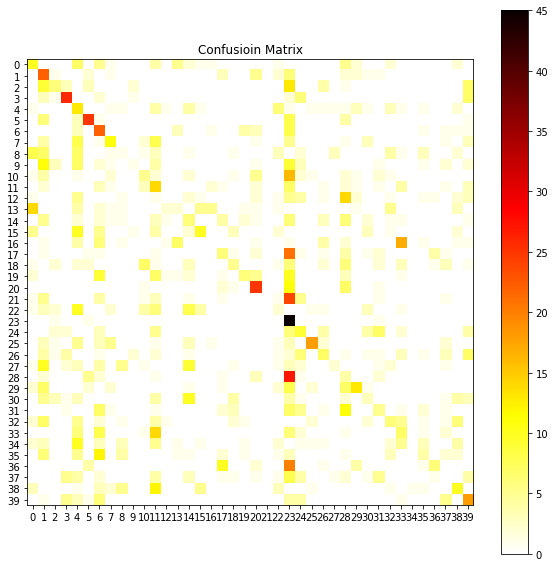

Accuracy of each class:
 tensor([0.2083, 0.4583, 0.1250, 0.5417, 0.2708, 0.5208, 0.4583, 0.2292, 0.0208,
        0.0208, 0.1042, 0.2917, 0.0000, 0.0417, 0.1250, 0.2083, 0.0000, 0.1250,
        0.1042, 0.1250, 0.5208, 0.0000, 0.0417, 0.9375, 0.1875, 0.3750, 0.1458,
        0.0417, 0.0833, 0.2708, 0.0625, 0.1042, 0.1250, 0.1458, 0.0000, 0.0833,
        0.1250, 0.0000, 0.2083, 0.3750])
Recall of each class:
 tensor([0.1818, 0.1679, 0.2609, 0.5306, 0.0992, 0.5435, 0.1818, 0.3333, 0.0417,
        0.1429, 0.1923, 0.1186, 0.0000, 0.1000, 0.0984, 0.3571, 0.0000, 0.1714,
        0.2174, 0.3750, 0.4167, 0.0000, 0.0625, 0.1475, 0.1552, 0.6667, 0.2059,
        0.2857, 0.0449, 0.4483, 0.1154, 0.1515, 0.1875, 0.1321, 0.0000, 0.1818,
        0.4615, 0.0000, 0.2439, 0.2727])
Epoch 8/40: , lr = 0.1
Step [10/60] Train Loss: 2.3606
Step [20/60] Train Loss: 2.3257
Step [30/60] Train Loss: 2.2366
Step [40/60] Train Loss: 2.4591
Step [50/60] Train Loss: 2.1159
Step [60/60] Train Loss: 2.2101
Accuracy on Tes

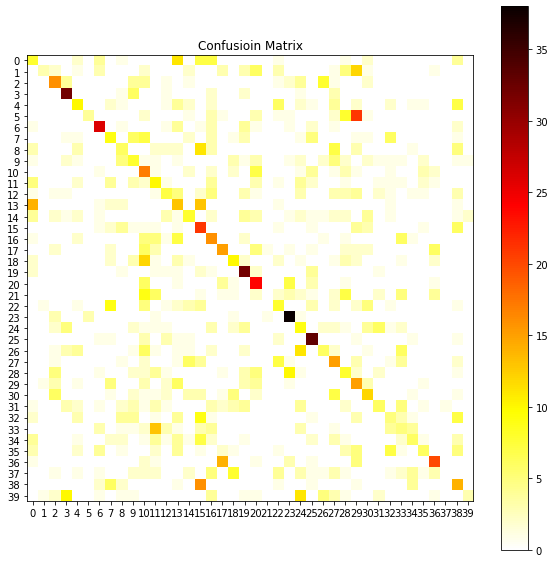

Accuracy of each class:
 tensor([0.1667, 0.0625, 0.3333, 0.6667, 0.2083, 0.0833, 0.5417, 0.1875, 0.1250,
        0.1667, 0.3542, 0.2083, 0.1458, 0.2708, 0.1667, 0.4375, 0.3333, 0.3125,
        0.2083, 0.6667, 0.5000, 0.0000, 0.1667, 0.7917, 0.1875, 0.6875, 0.1250,
        0.3125, 0.1667, 0.3125, 0.2500, 0.1250, 0.1042, 0.1042, 0.1250, 0.1250,
        0.4167, 0.0000, 0.2917, 0.0625])
Recall of each class:
 tensor([0.1509, 0.5000, 0.3404, 0.5161, 0.2564, 0.5714, 0.5098, 0.1915, 0.1667,
        0.1633, 0.1619, 0.1515, 0.2059, 0.1646, 0.2222, 0.2000, 0.2078, 0.3409,
        0.2632, 0.4324, 0.3288, 0.0000, 0.1905, 0.5429, 0.1364, 0.4925, 0.2308,
        0.2113, 0.1429, 0.1685, 0.2791, 0.2609, 0.1471, 0.1136, 0.2400, 0.3000,
        0.4878, 0.0000, 0.2121, 0.5000])
Epoch 9/40: , lr = 0.05
Step [10/60] Train Loss: 2.3188
Step [20/60] Train Loss: 2.2403
Step [30/60] Train Loss: 2.1302
Step [40/60] Train Loss: 2.1952
Step [50/60] Train Loss: 2.1584
Step [60/60] Train Loss: 2.2594
Accuracy on Te

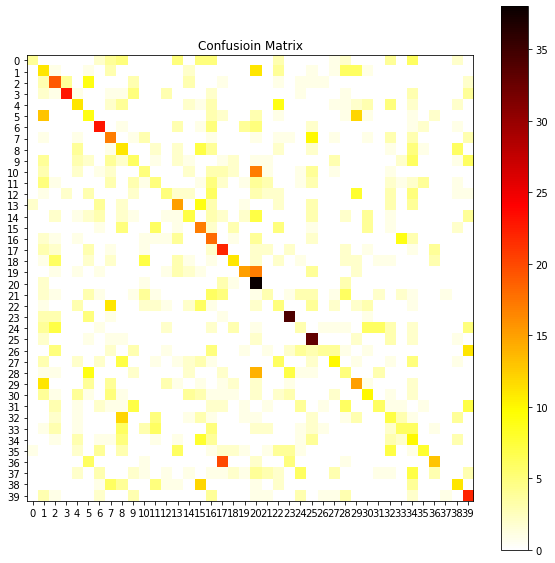

Accuracy of each class:
 tensor([0.0833, 0.2292, 0.3958, 0.4792, 0.2292, 0.1875, 0.4792, 0.3542, 0.2292,
        0.1250, 0.1042, 0.1042, 0.1042, 0.3125, 0.1458, 0.3542, 0.3750, 0.4583,
        0.2292, 0.3125, 0.7917, 0.0625, 0.1042, 0.7083, 0.0625, 0.6875, 0.0833,
        0.2083, 0.1042, 0.3125, 0.2083, 0.1250, 0.1458, 0.1250, 0.2083, 0.1667,
        0.2708, 0.0000, 0.2292, 0.4583])
Recall of each class:
 tensor([0.5714, 0.1279, 0.3065, 0.7931, 0.2500, 0.1500, 0.4423, 0.2361, 0.1507,
        0.1538, 0.1667, 0.1389, 0.2500, 0.2941, 0.2059, 0.2179, 0.1800, 0.3099,
        0.3667, 0.5357, 0.2533, 0.1429, 0.0943, 0.5667, 0.0938, 0.3667, 0.4444,
        0.3125, 0.1136, 0.2727, 0.2703, 0.3158, 0.1296, 0.2308, 0.1136, 0.5000,
        0.5000, 0.0000, 0.3056, 0.3235])
Epoch 10/40: , lr = 0.05
Step [10/60] Train Loss: 2.0827
Step [20/60] Train Loss: 2.0941
Step [30/60] Train Loss: 2.0764


KeyboardInterrupt: 

In [20]:
fit(net, num_epochs, optimizer, schedulr,device, nclasses)  #